In [1]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import sys
sys.path.insert(0,r'E:\Shabtay\dtlpy')
import dtlpy as dl
from dtlpy.ml import train_utils
%matplotlib inline  

# Get Global Model and Pretrained Snapshot

In [2]:
dl.setenv('prod')
project = dl.projects.get('COCO ors', '729659ec-6d7f-11e8-8d00-42010a8a002b')
# model = project.models.create(model_name='inceptionv3',
#                               output_type=dl.AnnotationType.CLASSIFICATION,
#                               is_global=True,
#                               src_path=r'E:\ModelsZoo\keras_adapters-main',
#                               entry_point='inception_adapter.py')
model = project.models.get('inceptionv3')

# pretrained snapshot
# snapshot = model.snapshots.create(snapshot_name='imagenet-pretrained',
#                                   dataset_id=None,
#                                   configuration={'weights_filename': 'model.hdf5',
#                                                  'classes_filename': 'classes.json',
#                                                  'input_shape': (299, 299)},
#                                   bucket=dl.LocalBucket(
#                                       local_path=r'E:\ModelsZoo\keras_adapters-main\pretrained_snapshot'),
#                                   labels=[])
snapshot = model.snapshots.get('imagenet-pretrained')
model.snapshots.list().to_df()

,id,creator,createdAt,name,description,is_global,status,tags,configuration,modelId,orgId,projectId,datasetId,bucket,ontologySpec
0,611d17d87e738bd26a4927c5,or@dataloop.ai,2021-08-18T14:23:20.522Z,imagenet-pretrained,My snapshot,False,created,[],"{'weights_filename': 'model.hdf5', 'classes_fi...",611d17a37e738b2d7f4927c3,18739a63-4393-43ea-a87e-9a284b14978f,729659ec-6d7f-11e8-8d00-42010a8a002b,None,"{'type': 'local', 'localPath': 'E:\ModelsZoo\k...","{'labels': [], 'ontologyId': '611d17d8fd776c03..."
1,611de93d1dad695cda520972,or@dataloop.ai,2021-08-19T05:16:45.531Z,sheep-soft-augmentations,My snapshot,False,created,[],"{'weights_filename': 'model.hdf5', 'classes_fi...",611d17a37e738b2d7f4927c3,18739a63-4393-43ea-a87e-9a284b14978f,729659ec-6d7f-11e8-8d00-42010a8a002b,611de92a84a72624dc758b1b,"{'type': 'local', 'localPath': 'E:\ModelsZoo\k...","{'labels': [], 'ontologyId': '611d17d8fd776c03..."


# Upload Dataset

In [9]:
dataset = project.datasets.get('Sheep Face')
dataset.to_df()

,id,name,annotated,creator,projects,itemsCount,driver,readableType,createdAt,accessLevel,readonly
0,61151cb9e5759208912b4e8e,Sheep Face,1680,or@dataloop.ai,[729659ec-6d7f-11e8-8d00-42010a8a002b],1681,rubiks_default_fs_driver,Master,2021-08-12T13:06:01.505Z,project,False


In [8]:
_ = dataset.items.upload(r'E:\Datasets\SheepFaceImages\*')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1681/1681 [00:07<00:00, 237.53it/s]


In [16]:
import os
pages = dataset.items.list()
for page in pages:
    for item in page:
        if item.annotated:
            continue
        if item.dir == '/':
            continue
        label=os.path.dirname(item.filename[1:])
        builder = item.annotations.builder()
        builder.add(dl.Classification(label=label))
        item.annotations.upload(builder)

# Run Pretrained Model

In [10]:
adapter = model.build()

In [11]:
adapter.load_from_snapshot(snapshot=snapshot,
                           local_path=snapshot.bucket.local_path)

I: dtlpy.ml.base_model_adapter 18:02:13 [inception_adapter.py:53](load):: Loaded model from E:\ModelsZoo\keras_adapters-main\pretrained_snapshot\model.hdf5 successfully


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

predicting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22bt/s]
I: dtlpy.ml.base_model_adapter 18:02:20 [base_model_adapter.py:226](predict_items):: Uploading  items annotation for snapshot 'imagenet-pretrained'. cleanup False
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.62it/s]


Classification: analog clock


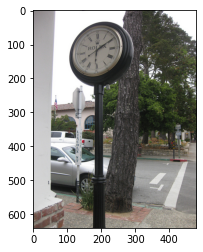

In [13]:
item = dl.items.get(item_id='611d1b18579405dff8a1be62')
annotations = adapter.predict_items([item], with_upload=True)
image = Image.open(item.download())
plt.imshow(item.annotations.show(np.asarray(image),
                                 thickness=5))
print('Classification: {}'.format(annotations[0][0].label))

In [17]:
item.open_in_web()

# Train on new dataset

In [3]:
dataset = project.datasets.get(dataset_name='Sheep Face')


partitions = {dl.SnapshotPartitionType.TRAIN: 0.8,
              dl.SnapshotPartitionType.VALIDATION: 0.2}
    
cloned_dataset = train_utils.prepare_dataset(dataset,
                                             filters=None,
                                             partitions=partitions)

# new_snapshot = snapshot.clone(name='sheep-soft-augmentations',
#                               dataset_id=cloned_dataset.id)

new_snapshot = model.snapshots.get(snapshot_name='sheep-soft-augmentations')

2021-08-19 17:30:36.953 [WARNING]-[MainThread]-[v1.35.2]dtlpy.ml.train_utils: Cloned dataset already exist. Using it...


In [4]:
adapter = model.build()
adapter.load_from_snapshot(snapshot=new_snapshot,
                           local_path=new_snapshot.bucket.local_path,
                           configuration=new_snapshot.configuration)

root_path, data_path, output_path = train_utils.prepare_training(snapshot=new_snapshot,
                                                                 adapter=adapter,
                                                                 root_path=os.path.join('tmp', new_snapshot.id))

I: dtlpy.ml.base_model_adapter 17:30:47 [inception_adapter.py:50](load):: Loaded model from E:\ModelsZoo\keras_adapters-main\20210819-081644\model.hdf5 successfully


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

2021-08-19 17:30:48.463 [WARNING]-[MainThread]-[v1.35.2]dtlpy.ml.train_utils: Data path directory (tmp\611de93d1dad695cda520972\data) is not empty..
  0%|                                                                                                                                                                                                             | 0/336 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336/336 [00:00<00:00, 2065.82it/s]


 10%|███████████████████▌                                                                                                                                                                                | 10/100 [00:00<00:00, 99.66it/s]2021-08-19 17:30:50.911 [WARNING]-[MainThread]-[v1.35.2]dtlpy.repositories.downloader: No items found! Nothing was downloaded

 50%|████████████

# Train the Cloned Snapshot

In [6]:
# Start the Train
print("Training {!r} with snapshot {!r} on data {!r}".format(model.name, new_snapshot.id, data_path))

adapter.snapshot.configuration = {'batch_size': 16,
                                  'start_epoch': 0,
                                  'num_epochs': 10,
                                  'input_size': (299,299)}
adapter.train(data_path=data_path,
              output_path=output_path)

Training 'inceptionv3' with snapshot '611de93d1dad695cda520972' on data 'tmp\\611de93d1dad695cda520972\\data'
Starting train with data at tmp\611de93d1dad695cda520972\data
Epoch 1/10
84/84 [==============================] - 32s 307ms/step - loss: 1.4509 - val_loss: 1252.5574
Epoch 2/10
84/84 [==============================] - 25s 295ms/step - loss: 1.4437 - val_loss: 852.4466
Epoch 3/10
84/84 [==============================] - 25s 294ms/step - loss: 1.4283 - val_loss: 1.6748
Epoch 4/10
84/84 [==============================] - 25s 292ms/step - loss: 1.4197 - val_loss: 1.4116
Epoch 5/10
84/84 [==============================] - 25s 295ms/step - loss: 1.4218 - val_loss: 474.0926
Epoch 6/10
84/84 [==============================] - 25s 295ms/step - loss: 1.4412 - val_loss: 1.3863
Epoch 7/10
84/84 [==============================] - 25s 296ms/step - loss: 1.4152 - val_loss: 86.9694
Epoch 8/10
84/84 [==============================] - 25s 295ms/step - loss: 1.4411 - val_loss: 13.6871
Epoch 9/10


I: dtlpy.ml.base_model_adapter 17:36:33 [inception_adapter.py:121](train):: Training completed


In [7]:
adapter.snapshot.bucket.list_content()

['classes.json', 'inception_v3.h5', 'model.hdf5']

In [10]:
adapter.save_to_snapshot(local_path=output_path,
                         replace=True,
                        weights_filename='model.hdf5')

In [11]:
adapter.snapshot.bucket.list_content()

['classes.json', 'model.hdf5']

In [13]:
snapshot.id

'611d17d87e738bd26a4927c5'

# Predict On New Snapshot

In [12]:
adapter = model.build()
trained_snapshot = model.snapshots.get(snapshot_name='sheep-soft-augmentations')
adapter.load_from_snapshot(snapshot=trained_snapshot,
                           local_path=trained_snapshot.bucket.local_path)

I: dtlpy.ml.base_model_adapter 10:31:18 [resnet_adapter.py:52](load):: Loading a model from E:\ModelsZoo\pytorch_adapters-master\tmp\snapshots\20210817-100709
I: dtlpy.ml.base_model_adapter 10:31:18 [resnet_adapter.py:57](load):: Loaded model from E:\ModelsZoo\pytorch_adapters-master\tmp\snapshots\20210817-100709\model.pth successfully


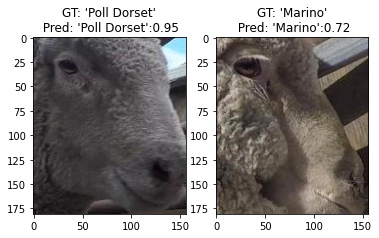

In [37]:
fig, ax = plt.subplots(1,2)
for i in range(2):
    image, target, orig_image, orig_targets = dataloader[np.random.randint(len(dataloader))]
    anno = adapter.predict([orig_image])
    ax[i].imshow(orig_image)
    ax[i].set_title('GT: {!r}\n Pred: {!r}:{:.2f}'.format(adapter.label_map[str(int(target))],
                                                          anno[0][0].label,
                                                          anno[0][0].metadata['user']['model']['confidence']))

# Predict and Upload Annotation to Item in Platform

In [12]:
dl.setenv('prod')
item = dl.items.get(item_id='6110d4a41467ded7a8c2a23d')
# adapter.load_from_snapshot(snapshot=snapshot,
#                            local_path=snapshot.bucket.local_path)
annotations = adapter.predict_items([item], with_upload=True)
image = Image.open(item.download())
plt.imshow(item.annotations.show(np.asarray(image),
                                 thickness=5))

predicting:   0%|                                                                                                                                                                                                   | 0/1 [00:00<?, ?bt/s]


AttributeError: 'list' object has no attribute 'read'